In [61]:
import pandas as pd
import numpy as np

test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [62]:
# 랜덤 시드를 고정하기 위한 코드
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

#### 버전 확인

In [89]:
#!pip list

/usr/local/lib/python3.8/dist-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/local/lib/python3.8/dist-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Package                             Version
----------------------------------- ---------------------
absl-py                             0.10.0
aiohttp                             3.8.1
aiosignal                           1.2.0
aiozmq                              0.9.0
alembic                             1.4.1
ansi2html                           1.7.0
anyio                               3.5.0
apache-beam                         2.34.0
appdirs                             1.4.3
argo-workflows                      3.6.1
argon2-cffi                         21.3.0
argon2-cffi-bindings     

### Data Preprocessing

#### 시계열 데이터 분할

In [63]:
def make_timeseries(data, what):
    data_list = []
    
    if what == 'train':
        col1 = data.iloc[:,6:95] # 새순 피처
        col2 = data.iloc[:,95:] # 엽록소 피처
    elif what == 'test':
        col1 = data.iloc[:,5:94] # 새순 피처
        col2 = data.iloc[:,94:] # 엽록소 피처
    
    tcol1 = col1.T
    tcol2 = col2.T
        
    tcol1.columns = data['ID']
    tcol2.columns = data['ID']+str('_1') # 새순과 엽록소 구분을 위해 '_1' 추가

    tcol1= tcol1.reset_index()
    date_lst = tcol1['index'].apply(lambda x: x.split('새')[0]) # 9월부터 11월까지 날짜 데이터를 추출하기 위해 data_lst를 만듦
    tcol1 = tcol1.drop('index', axis=1) 
    tcol2= tcol2.reset_index().drop('index', axis=1) 

    for id in data['ID']:
        # ID에 따라 각 날짜별 새순과 엽록소 값을 합친다음,
        md = pd.concat([tcol1[f'{id}'], tcol2[f'{id}_1']], axis=1)
        md = md.rename(columns = {f'{id}' : '새순', f'{id}_1' : '엽록소'})
        # 이후 나머지 피처값들을 받는다
        md['ID'] = id
        md['수고'] = float(data.loc[data['ID'] == id, '수고(m)'])
        md['수관폭_min'] = float(data.loc[data['ID'] == id, '수관폭1(min)'])
        md['수관폭_max'] = float(data.loc[data['ID'] == id, '수관폭2(max)'])
        md['수관폭_mean'] = float(data.loc[data['ID'] == id, '수관폭평균'])
        md['date'] = date_lst  
        data_list.append(md)

    td = pd.concat(data_list)

    return td

In [64]:
train1 = make_timeseries(train, 'train')
test1 = make_timeseries(test, 'test')

In [65]:
# 날짜 데이터에서 월 추출
train1['month'] = pd.to_datetime(train1.date).dt.month
train1 = train1.drop('date',axis=1)

test1['month'] = pd.to_datetime(test1.date).dt.month
test1 = test1.drop('date',axis=1)

In [ ]:
#새순

# 새순_diff = train1.groupby('ID').새순.diff().to_frame()
# train1['새순_diff'] =np.where(새순_diff.새순<-0.2,1,0)

# 새순_diff_te = test1.groupby('ID').새순.diff().to_frame()
# test1['새순_diff'] =np.where(새순_diff_te.새순<-0.2,1,0)

# 새순_diff = train1.groupby('ID').새순_diff.sum().reset_index()
# 새순_diff_te = test1.groupby('ID').새순_diff.sum().reset_index()

#### Describe Data

In [67]:
새순_describe = train1.groupby(['ID','month'])['새순'].describe().unstack().reset_index().drop('count',axis=1)
새순_describe.columns = ['ID','새순_mean_9','새순_mean_10','새순_mean_11',
            '새순_std_9','새순_std_10','새순_std_11','새순_min_9','새순_min_10',
            '새순_min_11','새순_25_9','새순_25_10', '새순_25_11', '새순_50_9',
            '새순_50_10', '새순_50_11','새순_75_9', '새순_75_10','새순_75_11',
            '새순_max_9', '새순_max_10', '새순_max_11']

새순_describe_te = test1.groupby(['ID','month'])['새순'].describe().unstack().reset_index().drop('count',axis=1)
새순_describe_te.columns = ['ID','새순_mean_9','새순_mean_10','새순_mean_11',
            '새순_std_9','새순_std_10','새순_std_11','새순_min_9','새순_min_10',
            '새순_min_11','새순_25_9','새순_25_10', '새순_25_11', '새순_50_9',
            '새순_50_10', '새순_50_11','새순_75_9', '새순_75_10','새순_75_11',
            '새순_max_9', '새순_max_10', '새순_max_11']

/tmp/ipykernel_252/1848495427.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  새순_describe = train1.groupby(['ID','month'])['새순'].describe().unstack().reset_index().drop('count',axis=1)
/tmp/ipykernel_252/1848495427.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  새순_describe_te = test1.groupby(['ID','month'])['새순'].describe().unstack().reset_index().drop('count',axis=1)


In [68]:
data = pd.merge(train.iloc[:,:6], 새순_describe, how='left', on='ID')
data = pd.merge(data, 엽록소_describe, how='left', on='ID')

data_te = pd.merge(test.iloc[:,:5], 새순_describe_te, how='left', on='ID')
data_te = pd.merge(data_te, 엽록소_describe_te, how='left', on='ID')

#### Heuristics Data

In [69]:
data['수관폭_diff'] = data['수관폭2(max)']-data['수관폭1(min)']
data['수관폭_rate'] = data['수관폭2(max)']/data['수관폭1(min)']
data['수관하중'] = data['수관폭평균']/data['수고(m)']

data_te['수관폭_diff'] = data_te['수관폭2(max)']-data_te['수관폭1(min)']
data_te['수관폭_rate'] = data_te['수관폭2(max)']/data_te['수관폭1(min)']
data_te['수관하중'] = data_te['수관폭평균']/data_te['수고(m)']

In [70]:
data['새순_mean_9_2'] = data['새순_mean_9']**2
# data['새순_25_9_2'] = data['새순_25_9']**2
# data['새순_50_9_2'] = data['새순_50_9']**2
data['새순_75_9_2'] = data['새순_75_9']**2
data['새순_max_9_2'] = data['새순_max_9']**2

data_te['새순_mean_9_2'] = data_te['새순_mean_9']**2
# data_te['새순_25_9_2'] = data_te['새순_25_9']**2
# data_te['새순_50_9_2'] = data_te['새순_50_9']**2
data_te['새순_75_9_2'] = data_te['새순_75_9']**2
data_te['새순_max_9_2'] = data_te['새순_max_9']**2

In [71]:
data = pd.concat([data, train.iloc[:,6:]],axis=1)
data_te = pd.concat([data_te, test.iloc[:,5:]],axis=1)

#### Data split

In [72]:
x_train = data.drop(['ID','착과량(int)'],axis=1)
y_train = data['착과량(int)']
x_test = data_te.drop(['ID'],axis=1)

#### Data Scaler

In [73]:
col_lst = x_train.columns

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train=pd.DataFrame(x_train,columns=col_lst)
x_test=pd.DataFrame(x_test,columns=col_lst)

### Feature Selection

In [75]:
from sklearn.linear_model import Ridge

from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score

from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

100% 95/95 [00:08<00:00, 11.47it/s]


(6, -34.37175569016353)


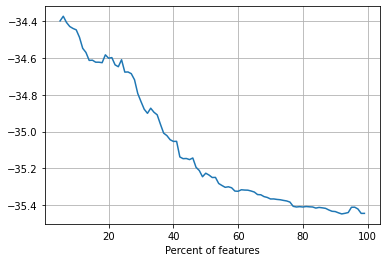

In [76]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = Ridge(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(x_train, y_train)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [77]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(x_train, y_train)
x_train_select = fs.transform(x_train)
x_test_select = fs.transform(x_test)

In [78]:
print(x_train_select.shape)
print(x_train.columns[fs.get_support()].tolist())

(2207, 14)
['새순_mean_9', '새순_50_9', '새순_75_9', '새순_max_9', '새순_mean_9_2', '새순_75_9_2', '새순_max_9_2', '2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-04 새순', '2022-09-05 새순', '2022-09-06 새순', '2022-09-07 새순']


In [79]:
x_train_select = pd.DataFrame(x_train_select, columns =x_train.columns[fs.get_support()].tolist())
x_test_select = pd.DataFrame(x_test_select, columns =x_test.columns[fs.get_support()].tolist())

### Modeling

In [81]:
# !pip install --upgrade ngboost

In [82]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal
from ngboost.scores import MLE
from ngboost.learners import default_tree_learner

def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [95]:
##### 0.07362
ngb = NGBRegressor(n_estimators=20000,  natural_gradient=True, 
                   learning_rate = 0.01,Base=default_tree_learner, 
                   Dist=Normal, Score=MLE, verbose_eval =50, random_state=0)

kf = KFold(n_splits = 5, shuffle=True, random_state=0)

ngb_pred_1 = np.zeros((x_test_select.shape[0]))
nmae_list = []
for tr_idx, val_idx in kf.split(x_train_select):
    tr_x, val_x = x_train_select.iloc[tr_idx], x_train_select.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 500)
    pred = ngb.predict(val_x)
    nmae = NMAE(val_y, pred)
    nmae_list.append(nmae)
    print(f'FOLD NMAE = {nmae}')
    sub_pred = ngb.predict(x_test_select) / 5
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} NMAE = {np.mean(nmae_list)}')

[iter 0] loss=6.8136 val_loss=6.7723 scale=1.0000 norm=189.9940
[iter 50] loss=6.1813 val_loss=6.1602 scale=2.0000 norm=154.2432
[iter 100] loss=5.7339 val_loss=5.7186 scale=2.0000 norm=75.9693
[iter 150] loss=5.3712 val_loss=5.3662 scale=2.0000 norm=60.1041
[iter 200] loss=5.1256 val_loss=5.1387 scale=2.0000 norm=57.4639
[iter 250] loss=4.9924 val_loss=5.0299 scale=2.0000 norm=56.7450
[iter 300] loss=4.9315 val_loss=4.9963 scale=2.0000 norm=56.2266
[iter 350] loss=4.9013 val_loss=4.9871 scale=2.0000 norm=55.8266
[iter 400] loss=4.8835 val_loss=4.9862 scale=2.0000 norm=55.5137
[iter 450] loss=4.8716 val_loss=4.9873 scale=2.0000 norm=55.2419
[iter 500] loss=4.8620 val_loss=4.9912 scale=2.0000 norm=55.0200
[iter 550] loss=4.8543 val_loss=4.9971 scale=2.0000 norm=54.8288
[iter 600] loss=4.8465 val_loss=5.0032 scale=2.0000 norm=54.6316
[iter 650] loss=4.8396 val_loss=5.0088 scale=2.0000 norm=54.4294
[iter 700] loss=4.8324 val_loss=5.0138 scale=2.0000 norm=54.2366
[iter 750] loss=4.8259 val

### Make_submission

In [99]:
sub['착과량(int)'] = ngb_pred_1
sub

,ID,착과량(int)
0,TEST_0000,247.580573
1,TEST_0001,758.260893
2,TEST_0002,144.427764
3,TEST_0003,446.459322
4,TEST_0004,686.965029
...,...,...
2203,TEST_2203,753.616102
2204,TEST_2204,317.476500
2205,TEST_2205,368.908945
2206,TEST_2206,251.372176


In [60]:
sub.set_index('ID').to_csv('sub/1213_v9.csv')